# Partition based time series clustering in aeon

Broadly speaking, clustering algorithms are either partitional or hierarchical. Partitional clustering algorithms assign (possibly probabilistic) cluster membership to each time series, usually through an iterative heuristic process of optimising some objective function that measures homogeneity.  Given a dataset of $n$ time series, $D$, the partitional time series clustering problem is to partition $D$ into $k$ clusters, $C = \{C_1, C_2, ..., C_k\}$ where $k$ is the number of clusters.

To measure homogeneity and place a time series into a cluster, a metric or distance is
used. For details of distances in aeon see the [distances examples](../distances/distances.ipynb). The distance is used to
compare a time series and assign cluster membership.

It is usually assumed that the number of clusters is set prior to the optimisation heuristic. If $k$ is not set, it is commonly found through some wrapper method. We assume $k$ is fixed in advance for all our experiments.

Currently, in aeon there are two types of time series partition algorithms
implemented: $k$-means and $k$-medoids.

## Imports and loading data

In [1]:
from sklearn.model_selection import train_test_split

from aeon.clustering.k_means import TimeSeriesKMeans
from aeon.clustering.k_medoids import TimeSeriesKMedoids
from aeon.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
from aeon.datasets import load_arrow_head

In [2]:
X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(158, 1, 251) (158,) (53, 1, 251) (53,)


## $k$-partition algorithms

$k$-partition algorithms are those that seek to create $k$ clusters and assign
each time series to a cluster using a distance measure. In aeon the
following are currently supported:

- $k$-means - one of the most well known clustering algorithms. The goal of
the $k$-means algorithm is to minimise a criterion known as the inertia or
within-cluster sum-of-squares (uses the mean of the values in a cluster as
the centre).

- K-medoids - A similar algorithm to K-means but instead of using the mean of
each cluster to determine the centre, the median series is used.

Algorithmically the common way to approach these k-partition algorithms is
known as Lloyds algorithm. This is an iterative process that involves:
- Initialisation
- Assignment
- Updating centroid
- Repeat assigment and updating until convergence

### Centre initialisation
Centre initialisation is the first step and has been found to be critical in
obtaining good results. There are three main centre initialisation that will
now be outlined:
<ul>
    <li> K-means, K-medoids supported centre initialisation:
        <ul>
            <li>Random - This is where each sample in the training dataset is
            randomly assigned to a cluster and update centres is run based on
            these random assignments i.e. for k-means the mean of these
            randomly assigned clusters is used and for k-medoids the median of
            these randomly assigned clusters is used as the initial centre.</li>
            <li>Forgy - This is where k random samples are chosen from the
            training dataset</li>
            <li>K-means++ - This is where the first centre is randomly chosen
            from the training dataset. Then for all the other time series in
            from the training dataset. Then for all the other time series in
            the training dataset, the distance between them and the randomly
            selected centre is taken. The next centre is then chosen from the
            training dataset so that the probability of being chosen is
            proportional to the distance (i.e. the greater the distance the
            more likely the time series will be chosen). The remaining
            centres are then generated using the same method. Thie means each
            centre will be generated so that the probability of a being
            chosen becomes proportional to its closest centre (i.e. the further
            from an already chosen centre the more likely it will be chosen).
            </li>
         </ul>
     </li>
 </ul>
 <br>
 These three cluster initialisation algorithms have been implemented and can
 be chosen to use when constructing either k-means or k-medoids partitioning
 algorithms by parsing the string values 'random' for random iniitialisation,
 'forgy' for forgy and 'k-means++' for k-means++.

### Assignment (distance measure)
How a time series is assigned to a cluster is based on its distance from it to
the cluster centre. This means for some k-partition approaches, different
distances can be used to get different results. While details on each of the
distances won't be discussed here the following are supported, and their
parameter values are defined:
<ul>
    <li>K-means, K-medoids supported distances:
        <ul>
            <li>Euclidean - parameter string 'euclidean'</li>
            <li>DTW - parameter string 'dtw'</li>
            <li>DDTW - parameter string 'ddtw'</li>
            <li>WDTW - parameter string 'wdtw'</li>
            <li>WDDTW - parameter string 'wddtw'</li>
            <li>LCSS - parameter string 'lcss'</li>
            <li>ERP - parameter string 'erp'</li>
            <li>EDR - parameter string 'edr'</li>
            <li>MSM - parameter string 'msm'</li>
            <li>TWE - parameter string 'twe'</li>
        </ul>
    </li>
</ul>

please see the [distances notebook](../distances/distances.ipynb) for more info
 on these functions.

### Updating centroids
centre updating is key to the refinement of clusters to improve their quality.
How this is done depends on the algorithm, but the following are supported
<ul>
    <li> K-means
        <ul>
            <li>Mean average - This is a standard mean average creating a new
             series that is that average of all the series inside the cluster.
             Ideal when using euclidean distance. Can be specified to use
             by parsing 'means' as the parameter for averaging_algorithm to
             k-means</li>
            <li>DTW Barycentre averaging (DBA) - This is a specialised
            averaging metric that is intended to be used with the dtw
            distance measure as it used the dtw matrix path to account for
            allignment when determining an average series. This provides a
            much better representation of the mean for time series. Can be
            specified to use by parsing 'dba' as the parameter for
            averaging_algorithm to k-means.</li>
        </ul>
    </li>
    <li> K-medoids
        <ul>
            <li>Median - Standard meadian which is the series in the middle of
            all series in a cluster. Used by default by k-medoids</li>
        </ul>
   </li>
   </li>
</ul>



## K-means clustering

<Figure size 500x1000 with 0 Axes>

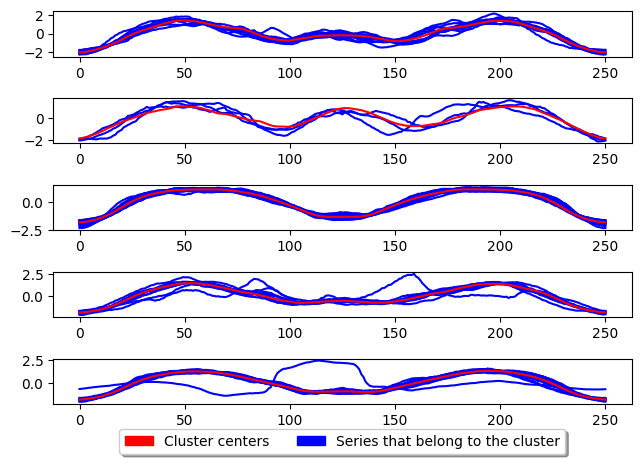

In [4]:
k_means = TimeSeriesKMeans(
    n_clusters=5,  # Number of desired centers
    init_algorithm="forgy",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    metric="dtw",  # Distance metric to use
    averaging_method="mean",  # Averaging technique to use
    random_state=1,
)

k_means.fit(X_train)
plot_cluster_algorithm(k_means, X_test, k_means.n_clusters)

<Figure size 500x1000 with 0 Axes>

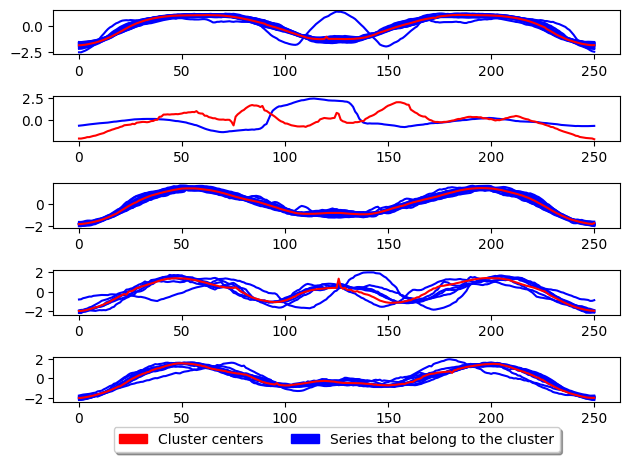

In [8]:
# Best configuration for k-means
k_means = TimeSeriesKMeans(
    n_clusters=5,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    metric="msm",  # Distance metric to use
    averaging_method="ba",  # Averaging technique to use
    random_state=1,
    average_params={
        "metric": "msm",
    },
)

k_means.fit(X_train)
plot_cluster_algorithm(k_means, X_test, k_means.n_clusters)

<h1>K-medoids</h1>
<h2>PAM</h2>

<Figure size 500x1000 with 0 Axes>

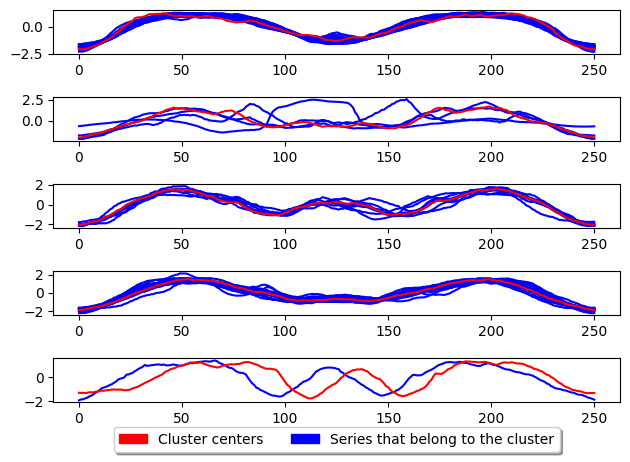

In [5]:
k_medoids = TimeSeriesKMedoids(
    n_clusters=5,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    verbose=False,  # Verbose
    distance="dtw",  # Distance metric to use
    random_state=1,
)

k_medoids.fit(X_train)
plot_cluster_algorithm(k_medoids, X_test, k_medoids.n_clusters)

The above shows the basic usage for K-medoids. This algorithm by default uses
the partition around medoids (PAM) algorithm to update the centres. The key
difference between this and k-means is that the centres are not generated
but are instead existing samples in the dataset. This means the centre is an
existing series in the dataset and NOT a generated one (the medoid).
<br><br>
The parameter key to k-medoids is the distance and is what we
can adjust to improve performance for time series. An example
of using msm as the metric is given below which has be shown to signicantly
improve the performance of k-medoids.


<Figure size 500x1000 with 0 Axes>

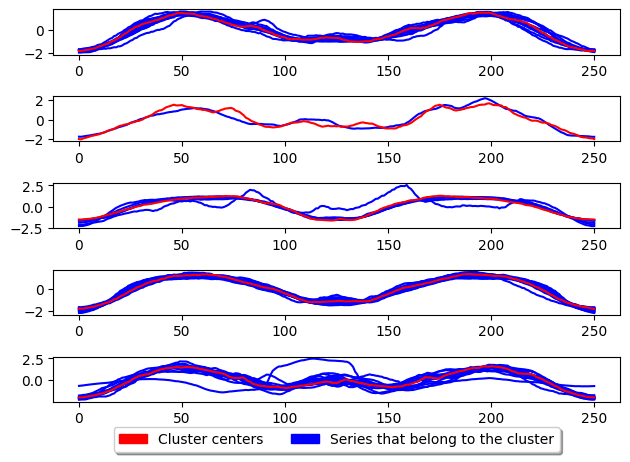

In [6]:
k_medoids = TimeSeriesKMedoids(
    n_clusters=5,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="msm",  # Distance metric to use
    random_state=1,
)

k_medoids.fit(X_train)
plot_cluster_algorithm(k_medoids, X_test, k_medoids.n_clusters)

<h2>Alternate k-medoids</h2>
<p>In addition there is another popular way of performing k-medoids which is
using the alternate k-medoids algorithm. This method adapts the Lloyd's algorithm
(used in k-means) but instead of using the mean average to update the centres
it uses the medoid. This method is generally faster than PAM however it is less
accurate. This method can be used by parsing 'alternate' as the parameter to
TimeSeriesKMedoids.</p>

<Figure size 500x1000 with 0 Axes>

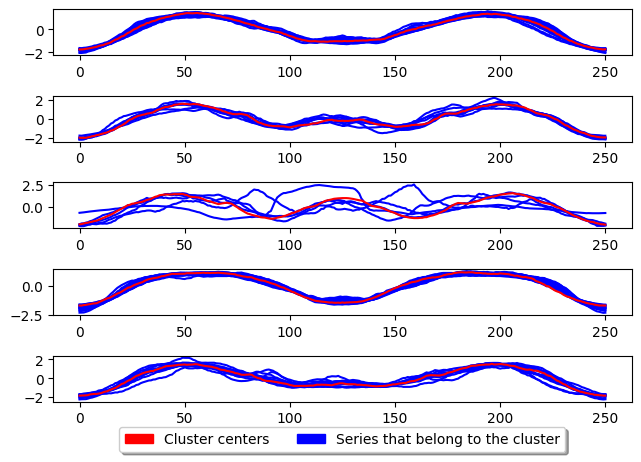

In [7]:
k_medoids = TimeSeriesKMedoids(
    n_clusters=5,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="msm",  # Distance metric to use
    random_state=1,
    method="alternate",
)

k_medoids.fit(X_train)
plot_cluster_algorithm(k_medoids, X_test, k_medoids.n_clusters)

<h2>CLARA</h2>
<p> Clustering LARge Applications (CLARA) improve the run time performance of
PAM by only performing PAM on a subsample of the the dataset to generate the
cluster centres. This greatly improves the time taken to train the model however,
degrades the quality of the clusters.

<Figure size 500x1000 with 0 Axes>

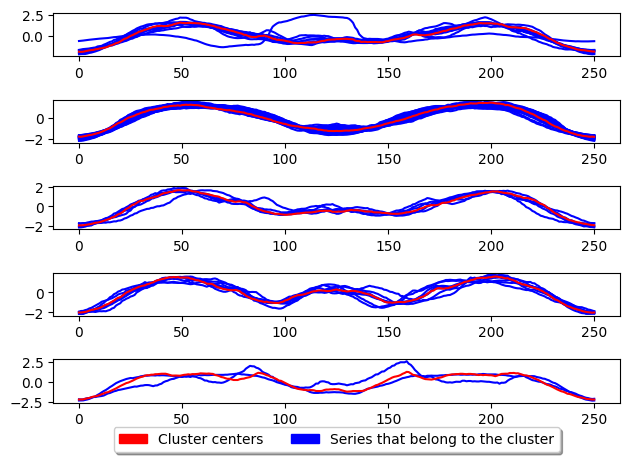

In [8]:
from aeon.clustering import TimeSeriesCLARA

clara = TimeSeriesCLARA(
    n_clusters=5,  # Number of desired centers
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="msm",  # Distance metric to use
    random_state=1,
)
clara.fit(X_train)
plot_cluster_algorithm(clara, X_test, clara.n_clusters)

<h2>CLARANS</h2>
<p>    CLARA based raNdomised Search (CLARANS) tries to improve the run time of
PAM by adapting the swap operation of PAM to
    use a more greedy approach. This is done by only performing the first swap which
    results in a reduction in total deviation before continuing evaluation. It limits
    the number of attempts known as max neighbours to randomly select and check if
    total deviation is reduced. This random selection gives CLARANS an advantage when
    handling large datasets by avoiding local minima.</p>

<Figure size 500x1000 with 0 Axes>

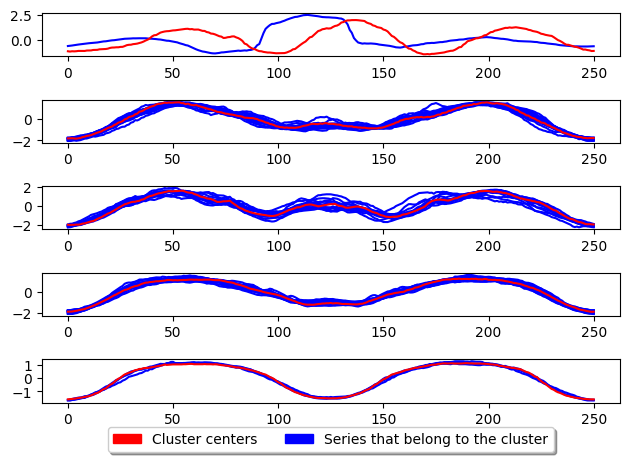

In [3]:
from aeon.clustering import TimeSeriesCLARANS

clara = TimeSeriesCLARANS(
    n_clusters=5,  # Number of desired centers
    distance="msm",  # Distance metric to use
    random_state=1,
)
clara.fit(X_train)
plot_cluster_algorithm(clara, X_test, clara.n_clusters)

## Background info and references for clusterers used here

#### TimeSeriesKmeans
One of the most popular TSCL approaches. The goal of the k-means algorithm is to minimise a criterion known as the inertia or within-cluster sum-of-squares (uses the mean of the values in a cluster as the centre). The best distance to use with
k-means is MSM [1] and the best averaging technique to use is MBA (to do this see above it is specified how to use barycentre averaging with MSM for k-means) [2].

[1] Christopher Holder, Matthew Middlehurst, and Anthony Bagnall. "A Review and Evaluation of Elastic Distance Functions for Time Series Clustering"  Knowledge and Information Systems (2023)
[2] Christopher Holder, David Guijo-Rubio, and Anthony Bagnall. "Barycentre averaging for the move-split-merge time series distance measure" 15th International Joint Conference on Knowledge Discovery, Knowledge Engineering and Knowledge Management

#### TimeSeriesKmedoids
TimeSeriesKmedoids is another popular TSCL approach. The goal is to partition n observations into k clusters in which each observation belongs to the cluster with the nearest medoid/centroid. There are two main variants which are PAM and alternate. PAM is the default and is the most accurate but is slower than alternate [3]. The best distance to use with all variants of k-medoids is MSM [1][3].

[3] Christopher Holder, David Guijo-Rubio, and Anthony Bagnall. "Clustering time series with k-medoids based algorithms" 8th Workshop on Advanced Analytics and Learning on Temporal Data (AALTD) at ECML-PKDD 2023

#### TimeSeriesCLARA
Clustering LARge Applications (CLARA) [4] is a clustering algorithm that samples the dataset, applies PAM to the sample, and then uses the medoids from the sample to seed PAM on the entire dataset. The algorithms main draw is its speed due to the subsample of data used to create the model. For comparison of performance see [3].

[4] Kaufman, Leonard & Rousseeuw, Peter. (1986). Clustering Large Data Sets. 10.1016/B978-0-444-87877-9.50039-X.

#### TimeSeriesCLARANS
CLARA based raNdomised Search (CLARANS) [1] adapts the swap operation of PAM use a more greedy approach. This is done by only performing the first swap results in a reduction in total deviation before continuing evaluation. It the number of attempts known as max neighbours to randomly select and check total deviation is reduced. This random selection gives CLARANS an advantage handling large datasets by avoiding local minima. CLARANS, similar to CLARA, aims to speed up PAM while only slightly degrading the quality of the clusters. For comparison of performance see [3].

[5] R. T. Ng and Jiawei Han, "CLARANS: a method for clustering objects spatial data mining," in IEEE Transactions on Knowledge and Data Engineering vol. 14, no. 5, pp. 1003-1016, Sept.-Oct. 2002, doi: 10.1109/TKDE.2002.1033770.

